# JHU covid-19 analysis
Log plot of cases per state 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import os
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 
from datetime import timedelta
import datetime
import pytz
from tzwhere import tzwhere
import JHUprocessing as jp
from matplotlib.dates import date2num       #-->Update 
from matplotlib.colors import ListedColormap


In [2]:
# general parameters

In [3]:
full_w = (12,7)
half_w = (6,4)

# load daily reports 

In [4]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0)  
    
    if  '03-13-2020' in file :
        # correct for mistake in JHU data set
        df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
        df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=2)  
         
    if  '03-09-2020' in file : 
        # correct for mistake in JHU data set
        df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
        df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=1) 
          
    df = df.append(df_temp, sort=True)  

# adjust column names and use only relevant columns

In [5]:
 
# convert both separately 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   # 
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime'] = pd.to_datetime(df['Last Update'] , unit='D'   ) 

### optional: convert times to pacific time 
df['Date'] = df['Datetime'].dt.date 

 
# compensate country/region
df['Country/Region'].isnull().sum() 
cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

# province state
cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered
2480,2020-04-01,Venezuela,NaN,99.0,143.0,3.0,41.0
2481,2020-04-01,Vietnam,NaN,155.0,218.0,0.0,63.0
2482,2020-04-01,West Bank and Gaza,NaN,115.0,134.0,1.0,18.0
2483,2020-04-01,Zambia,NaN,36.0,36.0,0.0,0.0
2484,2020-04-01,Zimbabwe,NaN,7.0,8.0,1.0,0.0


# create US only frame

In [6]:
bool_US = df['Country/Region'] =='US'
df_US = df[bool_US ]
df_US.head() # .groupby('Date (UTC)').sum().tail(15)

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered
31,2020-01-22,US,Washington,NaN,1.0,NaN,NaN
31,2020-01-23,US,Washington,NaN,1.0,NaN,NaN
33,2020-01-24,US,Washington,NaN,1.0,NaN,NaN
34,2020-01-24,US,Chicago,NaN,1.0,NaN,NaN
33,2020-01-25,US,Washington,NaN,1.0,NaN,NaN


# Create state entry

In [7]:
error_dict = {'Chicago':'Illinois',
            'NE (From Diamond Princess)':'Nebraska',
            'CA (From Diamond Princess)':'California',
            'TX (From Diamond Princess)':'Texas',
            'Unassigned Location (From Diamond Princess)':'Other',
            'D.C.':'District of Columbia',
            'Puerto Rico':'Other',
            'Guam':'Other',
            'U.S.':'Other',
            'US':'Other',
            'Virgin Islands':'Other',
            'United States Virgin Islands':'Other',
            'Wuhan Evacuee':'Other',
            'American Samoa':'Other',
            'Northern Mariana Islands':'Other',
#             'Northern Mariana Islands':'Other',
            'OR ':'Oregon'} 


def replace_state( x):
    state_entry = x['Province/State'].split(", ")[-1] 
    if state_entry in jp.state_dict.keys(): 
        new = jp.state_dict[ state_entry]  
    elif state_entry in error_dict.keys():
        new = error_dict[state_entry]  
    else:
        new = state_entry   
    return new 
         
df_US.loc[:,'State'] = df_US.apply(replace_state, axis=1)
 
### check washington frame
# bool_washington = df_US['Province/State'].str.contains('WA')
# df_US[bool_washington].groupby('Date').sum() 
# df_US[bool_washington] 

D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# create df_state 

In [8]:
df_state =  df_US.groupby(['State','Date']).sum().reset_index()
  
df_state = df_state.sort_values(by=['State','Date'], ascending=True )  
df_state.head() 

,State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-13,0.0,5.0,0.0,0.0
1,Alabama,2020-03-14,0.0,6.0,0.0,0.0
2,Alabama,2020-03-15,0.0,12.0,0.0,0.0
3,Alabama,2020-03-16,0.0,29.0,0.0,0.0
4,Alabama,2020-03-17,0.0,39.0,0.0,0.0


# drop some "states"

In [9]:
bool_other = df_state['State'].str.contains( 'Other' , regex=False)

print('df_US shape: ' , df_state.shape)
df_state.drop( df_state[bool_other].index, inplace=True) 
print('df_US shape: ' , df_state.shape)



bool_other = df_state['State'].str.contains( 'Princess' , regex=False)

print('df_US shape: ' , df_state.shape)
df_state.drop( df_state[bool_other].index, inplace=True) 
print('df_US shape: ' , df_state.shape)

df_US shape:  (1348, 6)
df_US shape:  (1323, 6)
df_US shape:  (1323, 6)
df_US shape:  (1289, 6)


# adjust california

In [10]:
bool_cal = df_state['State'] == 'California'
bool_prior = df_state['Date'] < datetime.datetime(2020,2,10).date()
 

df_state.loc[bool_cal & bool_prior,'Confirmed'] = 0 

# find day 0

In [11]:
 # set thresholds for day 0 
threshold_cases = 100
threshold_deaths = 10


last_day = df_state['Date'].max()
bool_last = df_state['Date'] == last_day
df_state.loc[bool_last,'Confirmed']  > threshold_cases 
states = df_state['State'].unique() 
threshold_states = []

for state in states: 
    bool_state = df_state['State'] == state  
    df_temp = df_state[bool_state].copy()
    
    bool_threshold_cases = df_temp['Confirmed'] >= threshold_cases
    if bool_threshold_cases.sum() > 0: 
        day0 = df_temp.loc[bool_threshold_cases,'Date'].iloc[0]
        threshold_states.append(state) 
    else: 
        day0 = last_day + timedelta(days=1) 

    newdays = (df_temp['Date'] - day0).dt.days  
    
    df_state.loc[bool_state,'Delta C'] = newdays
     
    
    bool_threshold_death = df_temp['Deaths'] >= threshold_deaths
    if bool_threshold_death.sum() > 0:
        day0 = df_temp['Date'][bool_threshold_death].iloc[0]
    else:
        day0 = last_day + timedelta(days=1) 
        
    newdays = (df_temp['Date'] - day0).dt.days 
    df_state.loc[bool_state,'Delta D'] = newdays 

    
df_state.head()

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D
0,Alabama,2020-03-13,0.0,5.0,0.0,0.0,-8.0,-16.0
1,Alabama,2020-03-14,0.0,6.0,0.0,0.0,-7.0,-15.0
2,Alabama,2020-03-15,0.0,12.0,0.0,0.0,-6.0,-14.0
3,Alabama,2020-03-16,0.0,29.0,0.0,0.0,-5.0,-13.0
4,Alabama,2020-03-17,0.0,39.0,0.0,0.0,-4.0,-12.0


In [12]:
# find doubling rate, average over last 3 days?  
average_period = 3

last_day = df_state['Date'].max() #- timedelta(days=3)
prior_day = df_state['Date'].max() - timedelta(days=average_period)

bool_last = df_state['Date'] == last_day
bool_prior = df_state['Date'] == prior_day
  
for state in states: 
    bool_state = df_state['State'] == state   
    
    ratio = df_state.loc[bool_last & bool_state,'Confirmed'].values[0]  / \
            df_state.loc[bool_prior & bool_state,'Confirmed'].values[0]   
    
    daily_ratio = ratio**(1/average_period)  
    
    df_state.loc[bool_state,'ratio'] = daily_ratio

    
bin_array = np.array( [0, 2.**(1./8), 2.**(1./7), 2.**(1./6), 2.**(1./5), 2.**(1./4) ,np.inf ]) 
bin_tick_labels = ['8','7','6','5','4']

df_state['doubling'] = pd.cut( df_state['ratio'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )
    
df_state['doubling'].unique()

df_state.head()

D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D,ratio,doubling
0,Alabama,2020-03-13,0.0,5.0,0.0,0.0,-8.0,-16.0,1.087136,0
1,Alabama,2020-03-14,0.0,6.0,0.0,0.0,-7.0,-15.0,1.087136,0
2,Alabama,2020-03-15,0.0,12.0,0.0,0.0,-6.0,-14.0,1.087136,0
3,Alabama,2020-03-16,0.0,29.0,0.0,0.0,-5.0,-13.0,1.087136,0
4,Alabama,2020-03-17,0.0,39.0,0.0,0.0,-4.0,-12.0,1.087136,0


In [13]:
# find doubling rate, average over last 3 days?  
average_period = 3

last_day = df_state['Date'].max() #- timedelta(days=3)
prior_day = df_state['Date'].max() - timedelta(days=average_period)

bool_last = df_state['Date'] == last_day
bool_prior = df_state['Date'] == prior_day
  
for state in states: 
    bool_state = df_state['State'] == state   
    
    ratio = df_state.loc[bool_last & bool_state,'Deaths'].values[0]  / \
            df_state.loc[bool_prior & bool_state,'Deaths'].values[0]   
    
    daily_ratio = ratio**(1/average_period)   
    if np.isnan(ratio):
        ratio = 1
        
    if np.isinf(ratio):
        ratio = 100
     
    df_state.loc[bool_state,'ratioD'] = daily_ratio

    bin_array = np.array( [-1, 2.**(1./20), 2.**(1./15), 2.**(1./10), 2.**(1./7), 2.**(1./5)  ,np.inf ]) 
df_state['doublingD'] = pd.cut( df_state['ratioD'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )

df_state['doublingD'] = df_state['doublingD'].fillna(0)

df_state['doublingD'].unique() 

D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
D:\D_program_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


[5, 4, 0, 3, 2]
Categories (5, int64): [0 < 2 < 3 < 4 < 5]

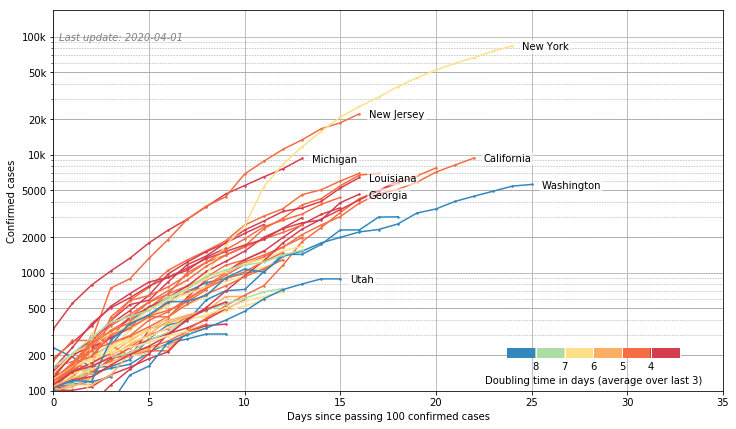

In [14]:
cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)

bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_states = ['New York','New Jersey','Michigan',"California",'Washington','Louisiana','Georgia','Utah' ]
# notable_states = threshold_states

fig, ax = plt.subplots(1,1 ,figsize= full_w )  
     
    
xCmax = df_state['Delta C'].max()
yCmax = df_state['Confirmed'].max()
xDmax = df_state['Delta D'].max()
yDmax = df_state['Deaths'].max()


for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    
    
    doubling_category = df_pl['doubling'].iloc[0]
    pl1 = ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])
      
    y = df_pl['Confirmed'].iloc[-1]*0.98
    x = df_pl['Delta C'].iloc[-1] + 0.5      
       
    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)
         
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   
 

ax.yaxis.set_ticks([1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,])
ax.yaxis.set_ticklabels([100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m'])

ax.set_xlim([0,xCmax+10])
ax.set_ylim([100,yCmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_cases) + " confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yCmax,5)*1.1], color=[.5,.5,.5], style='italic')


cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels(bin_tick_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_caseslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

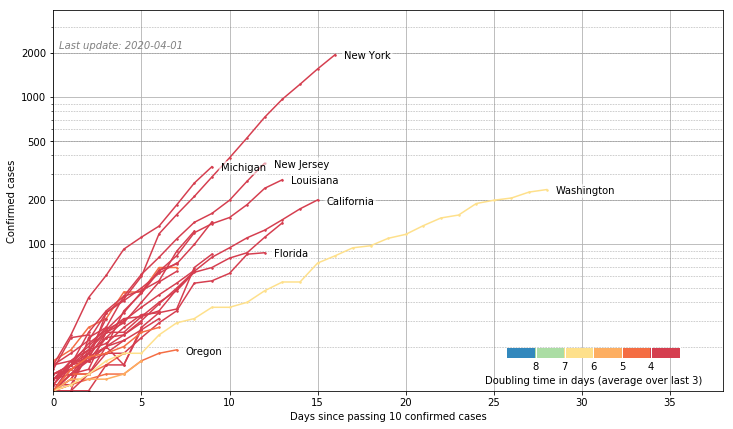

In [15]:
cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)

bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_states =   ['New York','New Jersey','Michigan',"California",'Washington','Louisiana',"Florida","Oregon"]
# notable_states = threshold_states

fig, ax = plt.subplots(1,1 ,figsize= full_w )  
     
xDmax = df_state['Delta D'].max()
yDmax = df_state['Deaths'].max()

for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    
    
    doubling_category = df_pl['doublingD'].iloc[0]
    pl1 = ax.plot( df_pl['Delta D' ],  df_pl['Deaths'],
            '.-' ,ms=3,lw=1.5, label=state,
               color = cols[doubling_category])
       
    y = df_pl['Deaths'].iloc[-1]*0.98
    x = df_pl['Delta D'].iloc[-1] + 0.5         
        
    if (state in notable_states) & (0 <=  x <= xCmax+10) & (10<= y <= yCmax*2): 
        t = ax.text(x,y,state, ha="left", va="center" ,  bbox=bbox_props)
          
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   



ax.yaxis.set_ticks([1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,])
ax.yaxis.set_ticklabels([100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m'])

ax.set_xlim([0,xDmax+10])
ax.set_ylim([10,yDmax*2])

ax.set_xlabel("Days since passing "+ str(threshold_deaths)+ " confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_state['Date'].iloc[-1]), 
            [.3,round(yDmax,5)*1.1], color=[.5,.5,.5], style='italic')


cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels(bin_tick_labels) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_deathslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

In [16]:
# sort states by confirmed cases on last date
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_states.head(5)  

sorted_names = sorted_states['State'].tolist()

sorted_names[:5]

['New York', 'New Jersey', 'California', 'Michigan', 'Massachusetts']

In [17]:
# df_state

# Highlight states

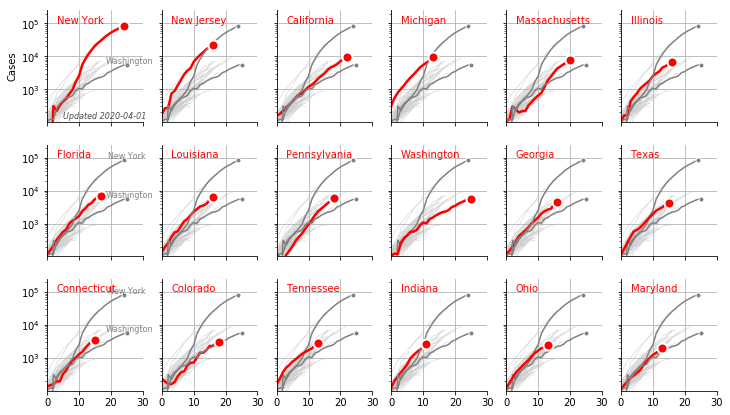

In [23]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'

dot_alpha = 1


notable_states = ['New York', 'Washington'  ]

def plot_highlight( ax_p, goal_state, df_state_pl):
    
    cmax = df_state_pl['Confirmed'].max()

    for state in threshold_states:
    #     print(state)
        if state == goal_state:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=2.5, label=state, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( state ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif state in notable_states:
#             print(state)
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=1.5, label=state, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta C' ].iloc[-1],  df_pl['Confirmed'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'-' ,
                    ms=3,lw=.5, label=state, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    ax_p.set_xlim([0,30])
    ax_p.set_ylim([100,cmax*3])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w)
 
for i, (ax_1, goal_state) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_state, df_state)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_state):
                bool_state = df_state['State'] == state 
                df_pl = df_state[bool_state] 

                y = df_pl['Confirmed'].iloc[-1]*1.1
                x = df_pl['Delta C'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
    ax_1.axes.get_yaxis().set_ticks([1e3,1e4,1e5])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Cases')

ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [5,130], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_casesHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

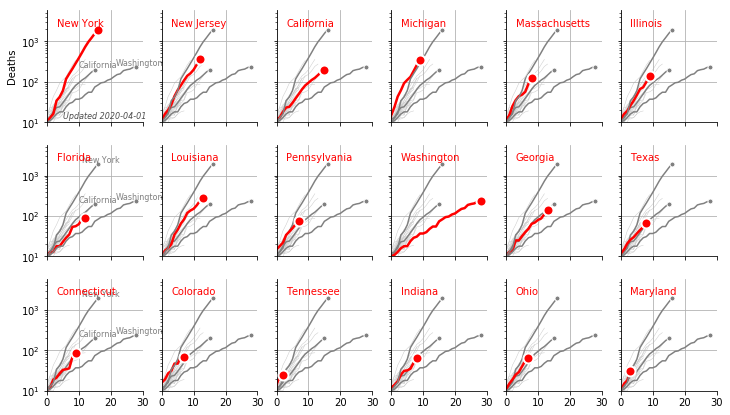

In [24]:
dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]
goal_col = 'red'
 
notable_states = ['New York' ,'Washington', 'California' ]

def plot_highlight( ax_p, goal_state, df_state_pl):
    
    cmax = df_state_pl['Deaths'].max()

    for state in threshold_states:
    #     print(state)
        if state == goal_state:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=2.5, label=state, 
                    color=goal_col ,alpha = dot_alpha) 
            ax_p.scatter( df_pl['Delta D' ].iloc[-1],  df_pl['Deaths'].iloc[-1], 100, goal_col,
                         edgecolors='w',zorder = 5, linewidths=2)  
            
            ax_p.annotate( state ,[3,cmax*1.2], color=goal_col, fontsize = 10,zorder = 5)
            
        elif state in notable_states:
#             print(state)
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=1.5, label=state, 
                    color=emph_col ,zorder = 2 ) 
            ax_p.plot( df_pl['Delta D' ].iloc[-1],  df_pl['Deaths'].iloc[-1], marker='.',
                      markersize=10, markerfacecolor=emph_col , 
                    markeredgecolor='w',markeredgewidth=1,zorder =3 ) 
        else:
            bool_state = df_state_pl['State'] == state 
            df_pl = df_state_pl[bool_state] 
            ax_p.plot( df_pl['Delta D' ],  df_pl['Deaths'],'-' ,
                    ms=3,lw=.5, label=state, 
                    color=dot_col ,alpha = dot_alpha,zorder = 1) 
             
    ax_p.set_yscale('log') 
    ax_p.set_xlim([0,30])
    ax_p.set_ylim([10,cmax*3])
#     ax_p.set_ylim([10,3e4])
    
    return ax_p

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w)
 
for i, (ax_1, goal_state) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
    ax_1 = plot_highlight(ax_1, goal_state, df_state)  
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for state in threshold_states:
            if (state in notable_states) &( state not in goal_state):
                bool_state = df_state['State'] == state 
                df_pl = df_state[bool_state] 

                y = df_pl['Deaths'].iloc[-1]*1.1
                x = df_pl['Delta D'].iloc[-1] + 1 
                ax_1.annotate( state ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
        
        
#     ax_1.axes.get_yaxis().set_ticks([1e2,1e3 ])
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
ax[0,0].set_ylabel('Deaths')

ax[0,0].annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [5,12], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_state_deathsHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

In [ ]:
df_state['Deaths'].max()